In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             
from collections import OrderedDict

In [32]:
#plot graph
def plotGaitAngle(list1,list2,list3):
    plt.plot(np.array(list1)) #blue R hip
    plt.plot(np.array(list2)) #orange R knee
    plt.plot(np.array(list3)) #green R ankle
    plt.ylabel('degree')
    plt.show()

#remove Nan from mylist
def crateListWithoutNan(mylist):
    newlist = []
    for i in mylist:
        if not pd.isnull(i):
            newlist.append(i)
    return newlist
    
class cameraKneeDataFrame:
    def __init__(self,df_pro,Vicon_rate = 100,camera_rate= 240):
        self.df_pro = df_pro
        if Vicon_rate > camera_rate:
            self.sampling_rate = camera_rate
            self.biggerValue = Vicon_rate
        else:
            self.sampling_rate = Vicon_rate
            self.biggerValue = camera_rate
        self.period = float(1/self.sampling_rate*self.biggerValue)
    #resampling mylist with new sampling rate
    def getNewSamplingList(self,mylist):
        reduced_list_len = float(len(mylist)/self.period)
        newlist = []
        for i in range(round(reduced_list_len)):
            if i*self.period<len(mylist):
                newlist.append(mylist[round(i*self.period)])
        return newlist

    
    def resamplingKneeList(self):
        self.cam_frame = self.getNewSamplingList(self.df_pro['frame'])
        self.cam_THIx = self.getNewSamplingList(self.df_pro['THIx'])
        self.cam_THIy = self.getNewSamplingList(self.df_pro['THIy'])
        self.cam_KNEx = self.getNewSamplingList(self.df_pro['KNEx'])
        self.cam_KNEy = self.getNewSamplingList(self.df_pro['KNEy'])
        self.cam_TIBx = self.getNewSamplingList(self.df_pro['TIBx'])
        self.cam_TIBy = self.getNewSamplingList(self.df_pro['TIBy'])
    
    def getKneeDataFrame(self):
        self.resamplingKneeList()
        new_camera_list =  OrderedDict([('THIx',self.cam_THIx),('THIy',self.cam_THIy),('KNEx',self.cam_KNEx)\
                                        ,('KNEy',self.cam_KNEy),('TIBx',self.cam_TIBx),('TIBy',self.cam_TIBy)])
        self.new_camera_df = pd.DataFrame.from_dict(new_camera_list)
        self.new_camera_df_list = self.new_camera_df.values.tolist()
        
        return self.new_camera_df 

#crate normalized knee angle        
def normalizeList(mylist,shift,Max):    
    newlist = []
    Max = Max + shift
    for i in mylist:
        i = (i+shift)/Max
        if i > 1: 
            i=1
        newlist.append(i)
    return newlist
def encodeList(mylist,shift,mul):
    newlist = []
    for i in mylist:
        i = int((i+shift)*mul)
        newlist.append(i)
    return newlist
#crate dataframe of dataset
class DataSet:
    def __init__(self,frameMatch,ViconDataIndex,new_camera_df_list,list_kneeAngleN):
        self.new_camera_df_list = new_camera_df_list
        self.kneeColumnN = list_kneeAngleN
        #match vicon amd cam then out put listX amd listY

        #Vicon match point index115
        #start 0 
        #end128

        #Camera match point index213
        #start 213-115 =98
        #end (128-115)+213= 226
        #check 226-98 = 128 ok
        self.viconstart = 0
        self.viconend = len(self.kneeColumnN)-1 #131
        self.camstart = frameMatch - ViconDataIndex
        self.camend = (self.viconend-ViconDataIndex)+frameMatch 
        self.diff = frameMatch-ViconDataIndex

        #pat = [
        #        [[0.3,0.4], [0.5]],
        #        [[0.3,0.5], [0.6]],
        #        [[0.4,0.5], [0.6]],
        #        [[0.9,0.3], [0.4]]
        #    ]
    def getList(self):
        self.pat = []
        if self.viconend - self.viconstart == self.camend-self.camstart:  
            for i in range(self.viconstart,self.viconend):
                a = self.new_camera_df_list[i+self.diff].copy()
                a.append(self.kneeColumnN[i])
                self.pat.append(a)    
            return self.pat
        else:
            print("array size error")
    def getDataFrame(self):
        self.getList()
        listOfDf= []
        header = ['THIx','THIy','KNEx','KNEy','TIBx','TIBy','knee angle']
        for i in self.pat:
            listOfDf.append( tuple(i))
        self.df = pd.DataFrame.from_records(listOfDf, columns=header)
        return self.df
        

In [35]:
#input function 

#User setup here
vicon_source = 'walking_gait_output_excel2/WALKING 10.csv'
column_label = 15
camera_source = 'Knee_markers_excel/excelR10N.csv'
#User end

#input Vicon data
df = pd.read_csv(vicon_source,header=[column_label-1,column_label],engine='python',skip_blank_lines = False)
a = df.columns.get_level_values(0).to_series()
b = a.mask(a.str.startswith('Unnamed')).ffill().fillna('')
df.columns = [b, df.columns.get_level_values(1)]

#df = pd.read_csv(vicon_source,header=[column_label -1],engine='python',skip_blank_lines = False)
#df_np = np.array(df) 
#input camera data
df_pro = pd.read_csv(camera_source,sep = ',',engine='python')
df_pro_np = np.array(df_pro)   

In [36]:
df

LASI                                RASI              \
     Field #           X           Y           Z           X           Y   
0        101  228.381454   170.34935  913.702454  524.187561  116.112595   
1        102  225.106186  180.294144  915.997742  520.550598  128.476578   
2        103  221.973495  190.079391  918.138733  517.100891  140.517334   
3        104   218.98378  199.705505  920.125916  513.839111  152.235306   
4        105  216.138229  209.173615  921.960938   510.76712  163.631744   
5        106  213.438889  218.485931  923.647034  507.887695  174.709351   
6        107  210.888702  227.645905  925.190063  505.204285  185.472809   
7        108  208.491135  236.658356   926.59845  502.720459  195.929321   
8        109  206.249512  245.529327  927.883423  500.438721  206.089066   
9        110  204.166336  254.266052  929.059021  498.359528  215.965332   
10       111   202.24263  262.876648  930.140991  496.480255  225.574615   
11       112  200.477341  271.369904  931.146118  494.794281  234.936493   
12       113  198.866821  279.755035  932.090881  493.290924  244.073563   
13       114   197.40451  288.041748  932.989807  491.955688  253.011169   
14       115  196.080765   296.23999  933.854431   490.77066  261.777191   
15       116  194.882935  304.360168  934.691956  489.715698   270.40152   
16       117  193.795715  312.413208  935.504517  488.769196  278.915558   
17       118  192.801666  320.410614  936.288635  487.909271  287.351593   
18       119  191.882004  328.364502  937.035767  487.114777  295.742126   
19       120  191.017563  336.287659  937.732483   486.36615  304.119049   
20       121  190.189728  344.192963  938.361877  485.646088  312.513092   
21       122  189.381256  352.093048  938.904968  484.940063  320.952972   
22       123  188.577103  359.999481  939.341736  484.236786  329.464905   
23       124  187.765091  367.922668  939.653198  483.528137   338.07196   
24       125  186.936401  375.871582  939.822449  482.809235  346.793762   
25       126  186.085983  383.853973  939.835754  482.078278  355.646179   
26       127  185.212692  391.876465  939.683716  481.336304  364.641052   
27       128  184.319275  399.945007  939.361633  480.586761  373.786346   
28       129  183.412247  408.065247  938.869629  479.835083  383.086212   
29       130   182.50148   416.24292  938.212463   479.08844  392.541321   
...      ...         ...         ...         ...         ...         ...   
2947    2381         NaN         NaN         NaN         200         300   
2948    2382         NaN         NaN         NaN         200         300   
2949    2383         NaN         NaN         NaN         200         300   
2950    2384         NaN         NaN         NaN         200         300   
2951    2385         NaN         NaN         NaN         200         300   
2952    2386         NaN         NaN         NaN         200         300   
2953    2387         NaN         NaN         NaN         200         300   
2954    2388         NaN         NaN         NaN         200         300   
2955    2389         NaN         NaN         NaN         200         300   
2956    2390         NaN         NaN         NaN         200         300   
2957    2391         NaN         NaN         NaN         200         300   
2958    2392         NaN         NaN         NaN         200         300   
2959    2393         NaN         NaN         NaN         200         300   
2960    2394         NaN         NaN         NaN         200         300   
2961    2395         NaN         NaN         NaN         200         300   
2962    2396         NaN         NaN         NaN         200         300   
2963    2397         NaN         NaN         NaN         200         300   
2964    2398         NaN         NaN         NaN         200         300   
2965    2399         NaN         NaN         NaN         200         300   
2966    2400         NaN         NaN         NaN         200        

In [15]:
#Run this cell for right side
HipAngle = "RHipAngles"
KneeAngle = "RKneeAngles"
AnkleAngle = "RAnkleAngles"

In [17]:
#Run this cell for left side
HipAngle = "LHipAngles"
KneeAngle = "LKneeAngles"
AnkleAngle = "LAnkleAngles"

In [18]:
#check in put and crate list of normalized knee angle
print(df[HipAngle,"X"][0])#first hip angle
print(df[KneeAngle,"X"][0])#first Knee angle
print(df[AnkleAngle,"X"][0])#first ankle angle

#create list of knee angle with out nan
list_kneeAngle  = crateListWithoutNan(df["LKneeAngles","X"])

#crate normalized list of knee angle
#list_kneeAngleN = normalizeList(list_kneeAngle,10,50)

#encode
list_kneeAngleE = encodeList(list_kneeAngle,10,100)

22.257664000000002
-4.415087000000001
1.248215


In [27]:
list_kneeAngle

[-4.415087000000001,
 -4.958133999999999,
 -5.3761220000000005,
 -5.668979,
 -5.836627,
 -5.878557,
 -5.793723,
 -5.580033,
 -5.233493,
 -4.748267,
 -4.116453,
 -3.3291470000000003,
 -2.378643,
 -1.261042,
 0.019793,
 1.447865,
 2.991693,
 4.60324,
 6.221757,
 7.781821000000001,
 9.222919000000001,
 10.497108,
 11.573724,
 12.440263999999999,
 13.100285000000001,
 13.569366,
 13.869778,
 14.0262,
 14.062368,
 13.999654999999999,
 13.856576,
 13.649410000000001,
 13.392477,
 13.098711999999999,
 12.779684,
 12.445461,
 12.103886,
 11.759861,
 11.414603,
 11.065613,
 10.707216,
 10.331907000000001,
 9.932297,
 9.503219,
 9.043405,
 8.556442,
 8.050357,
 7.5365779999999996,
 7.027991,
 6.537297,
 6.075394999999999,
 5.650453,
 5.267537,
 4.928778,
 4.634027,
 4.381525,
 4.168948,
 3.994015,
 3.854911,
 3.7504779999999998,
 3.6799910000000002,
 3.6426230000000004,
 3.636904,
 3.6603220000000003,
 3.709172,
 3.7787040000000003,
 3.8635129999999998,
 3.958108,
 4.0576,
 4.158487,
 4.259162,


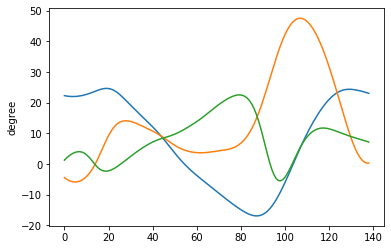

In [20]:
#display graph for matching
plotGaitAngle(df[HipAngle,"X"],df[KneeAngle,"X"],df[AnkleAngle,"X"])
#blue R hip
#orange R knee
#green R ankle

In [21]:
#crate pandas dataframe of camera data
#User setup here
Vicon_rate = 100
camera_rate = 240 #30fps * 8
frameMatch = 257 #approximate frame that is IC
ViconDataIndex = 53  #row of your value in excel minus first row in excel 
#User end


camKDF = cameraKneeDataFrame(df_pro)
#create camera dataframe
cam_df = camKDF.getKneeDataFrame()
#crate list if camera dataframe
cam_df_list = camKDF.new_camera_df_list


In [22]:
print(cam_df)

          THIx                THIy       KNEx                KNEy       TIBx  \
0         None                None       None                None       None   
1         None                None       None                None       None   
2         None                None       None                None       None   
3         None                None       None                None       None   
4         None                None       None                None       None   
5         None                None       None                None       None   
6         None                None       None                None       None   
7         None                None       None                None       None   
8         None                None       None                None       None   
9         None                None       None                None       None   
10        None                None       None                None       None   
11        None                None      

In [25]:
DS = DataSet(int(frameMatch/camKDF.period),ViconDataIndex,cam_df_list,list_kneeAngleE)
#create list of dataset
ds_list = DS.getList()
#create data set
ds_df = DS.getDataFrame()

In [24]:
#for i in ds_list:print(i)
print(ViconDataIndex)
print(frameMatch)
print(ds_list[ViconDataIndex])

53
257
['0.503125', '0.529891304347826', '0.5203125', '0.6168478260869565', '0.534375', '0.7309782608695652', 1492]


In [72]:
#save in excel
#User setup here
fileName = "walkR10.csv"
save_path = "matched_excel/"
#User end

ds_df.to_csv (save_path+fileName, index = None, header=True) 